In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')

## Data Aquisition

Download some large number of datapoints split into several datasets.

In [101]:
import priceanalytics.data as data

big_df = data.alpaca_download_single(
    'AAPL',     
    past_days=30, 
    interval=1
)
dfs = data.split_alpaca_on_day(big_df)
print(sum([len(df) for df in dfs]))

7410


Normalize the data and ensure no loss.

7410


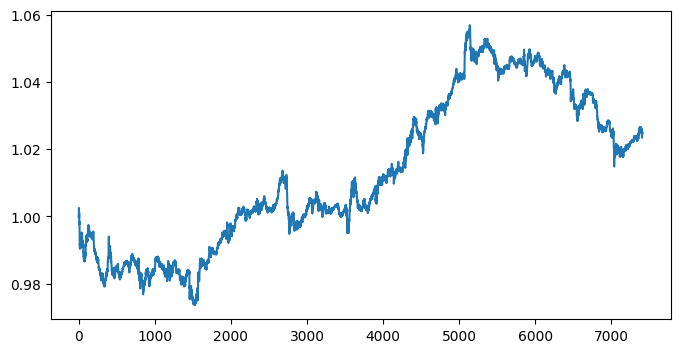

In [147]:
normalized = data.normalize_dataset(dfs, lambda df: df['close'].to_numpy())
print(len(normalized))

import pandas as pd
import numpy as np
import priceanalytics.plot as plot
import matplotlib.pyplot as plt

with plot.MultiPlot(1, size=(8, 4)) as m:
    plt.plot(normalized)

## Log-Return Analysis 

Compute log-returns and plot.

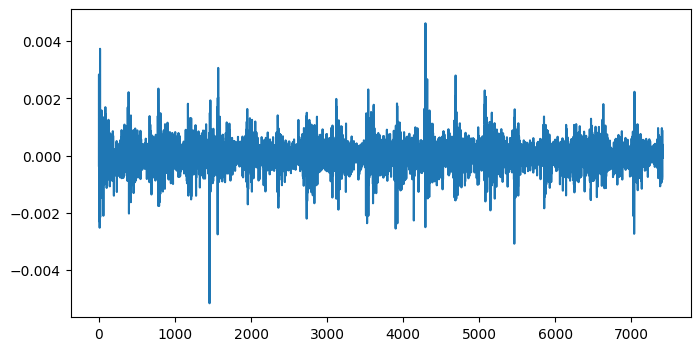

In [104]:
log_returns = np.diff(np.log(normalized))
    
with plot.MultiPlot(1, size=(8, 4)) as m:
    plt.plot(log_returns)

Model log-returns using the *student's t* distribution. 

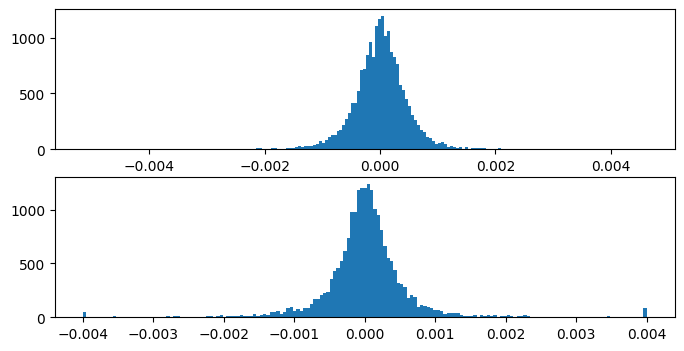

In [146]:
from scipy.stats import t

dof, loc, scale = t.fit(log_returns)
mean, var, skew, kurt = t.stats(dof, moments='mvsk') 

random = t.rvs(dof, loc=loc, scale=scale, size=len(log_returns))
minmax = lambda x: max(min(x, .004), -.004)  # remove outliers 
random = np.array([minmax(x) for x in random])

with plot.MultiPlot(2, size=(8, 4)) as m:
    plt.hist(log_returns, bins='auto', density=True)
    m.next()
    plt.hist(random, bins='auto', density=True)


Dear Justus (future),

You must create a decision model which, when tested on a large set of random stochastic futures, is sufficeintly likely to produce a possitive return. 

Regards, 
Justus (past)